# Structural Topic Model (STM)

##### Author information
- **Name:** Jaeseong Choe

- **email address:** 21900759@handong.ac.kr

- **GitHub:** https://github.com/sorrychoe

- **Linkedin:** https://www.linkedin.com/in/jaeseong-choe-048639250/

- **Personal Webpage:** https://jaeseongchoe.vercel.app/

## Part 1. Brief background of methodology

### Overview

- **Structural Topic Model(STM) incorporates document-level metadata into the topic modeling process**. 

- It allows **the inclusion of external information (metadata) to influence the document's topic distribution**.


### Situation Before STM

- Topic models like LDA treat documents independently and ignore document-specific covariates.

### Why STM Was Introduced

- STM was introduced from the paper *"A model of text for experimentation in the social sciences."* of Roberts, M. E., Stewart, B. M., & Airoldi, E. M. (2016).

- STM allows for incorporating document-level metadata (e.g., author, date) to influence topic discovery.

### Use Cases

- STM is useful for analyzing how different factors (e.g., authorship, political affiliation) affect topic prevalence.

## Part 2. Key concept of methodology

### Key Concept

- STM incorporates metadata as a covariate affecting the topic distribution, allowing document-specific factors to influence topic discovery.

### Generative Process

1. **Covariate Effect on Topic Prevalence**:
   - For each document $d$, the topic distribution $\theta_d$ is influenced by covariates $X_d$. The topic proportions $\theta_d$ are drawn from a logistic normal distribution:
   $$
   \theta_d \sim \text{LogisticNormal}(\mu_d, \Sigma)
   $$
   where $\mu_d = X_d \gamma$, and $\Sigma$ is the covariance matrix.

2. **Topic Assignment**:
   - For each word $w_{dn}$ in document $d$, draw a topic assignment $z_{dn}$ from a multinomial distribution:
   $$
   z_{dn} \sim \text{Multinomial}(\theta_d)
   $$

3. **Covariate Effect on Topic Content**:
   - The word distribution $\beta_k$ for topic $k$ depends on the covariates $Y_d$. The distribution over words is modeled as a multinomial logistic regression:
   $$
   \beta_{d,k,v} \propto \exp(m_v + \kappa_k^{(t)} + \kappa_v^{(c)} + \kappa_{kv}^{(i)})
   $$
   where:
   - $m_v$ is the marginal log frequency of term $v$,
   - $\kappa_k^{(t)}$ is the topic-specific effect,
   - $\kappa_v^{(c)}$ is the covariate-specific effect,
   - $\kappa_{kv}^{(i)}$ is the topic-covariate interaction effect.

4. **Word Generation**:
   - For each word $w_{dn}$, draw a word from the multinomial distribution based on the assigned topic $z_{dn}$:
   $$
   w_{dn} \sim \text{Multinomial}(\beta_{z_{dn}})
   $$

![STM_Graphic](./img/STM_Graphic.png)

### Mathematical Representation

- **Topic Prevalence Model**:
   The topic proportions $\theta_d$ are modeled as a logistic normal distribution:
   $$
   \theta_d = \frac{\exp(\eta_d)}{\sum_k \exp(\eta_d,k)}
   $$
   where $\eta_d \sim \mathcal{N}(X_d \gamma, \Sigma)$.

- **Topic Content Model**:
   The word distribution for each topic $\beta_k$ is influenced by the covariates $Y_d$:
   $$
   \beta_{k,v} \propto \exp(m_v + \kappa_k^{(t)} + \kappa_v^{(c)} + \kappa_{kv}^{(i)})
   $$

### Inference

STM uses **variational expectation-maximization (EM)** for approximate inference due to the non-conjugacy of the logistic normal distribution with the multinomial likelihood.

- **Variational E-Step**:
   The variational posterior for $\eta_d$ is approximated using a Laplace approximation:
   $$
   q(\eta_d) \approx \mathcal{N}(\lambda_d, \nu_d)
   $$
   where $\lambda_d$ is the mode of $\eta_d$, and $\nu_d$ is the Hessian of the log-posterior.

- **Variational M-Step**:
   The M-step maximizes the ELBO with respect to the model parameters $\gamma, \kappa, \Sigma$. The updates for $\gamma$ are obtained through linear regression, while $\beta$ is updated using a multinomial logistic regression.

### Strength

- STM captures how external factors affect topic prevalence and topic content.

## Part 3. Example

### Before Sample code

- No library exists that implements stm exactly as the formula stated in the paper in Python. 

- However, there exists in R. Because of this reason, All codes are written in R.

- In this sample code, I use the `stm` package of R

### Precautions

- If you re-execute the code, there may be a slight difference in the result.

- Of course, the difference in the number or content of the topic will not be significant due to the seed number and the learning rate, but the number of the topic changes.

In [1]:
# import librarys
library(stm) # for stm 
library(tidyverse) # for Data preprocessing(dplyr, tidyr), visualization(ggplot2) & use pipeline operator(magrittr)
library(tidytext) # for Text preprocessing
library(tm) # for Text preprocessing
library(showtext) # for set the Korean font
library(readxl) # for load excel data

font_add_google(name = "Nanum Gothic", family = "nanumgothic") # korean font setup
showtext_auto()

# set the seed number
set.seed(42)

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
필요한 패키지를 로딩중입니다: NLP


다음의 패키지를 부착합니다: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


필요한 패키지를 로딩중입니다: sysfonts

필요한 패키지를 로딩중입니다: showtextdb



In [2]:
# data load
# The data is related to Handong University, 
# which was reported in major Korean daily newspapers from January 1995 to September 2024.
df <- read_xlsx("data/NewsResult_19950101-20240930.xlsx")

# data preprocessing
df$키워드 <- gsub(",", " ", df$키워드)

df$Date <- as.Date(df$일자, format = "%Y%m%d")

df$Press <- as.factor(df$언론사)

# Process a vector of raw texts
processed <- textProcessor(documents = df$키워드, metadata = df)

# Prepare documents for analysis
out <- prepDocuments(processed$documents, processed$vocab, processed$meta)

# add meta data at documents
out$meta$Date <- df$Date
out$meta$Press <- df$Press

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 58361 of 98864 terms (58361 of 453771 tokens) due to frequency 
Your corpus now has 8051 documents, 40503 terms and 395410 tokens.

In [3]:
# find proper k value
topicN <- seq(3, 10)
topicN_storage <- searchK(out$documents, out$vocab, K = topicN) 
# searchK() is non-deterministic, It is outside the influence of the seed number.

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	...
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.560) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.758, relative change = 8.383e-02) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -8.746, relative change = 1.45

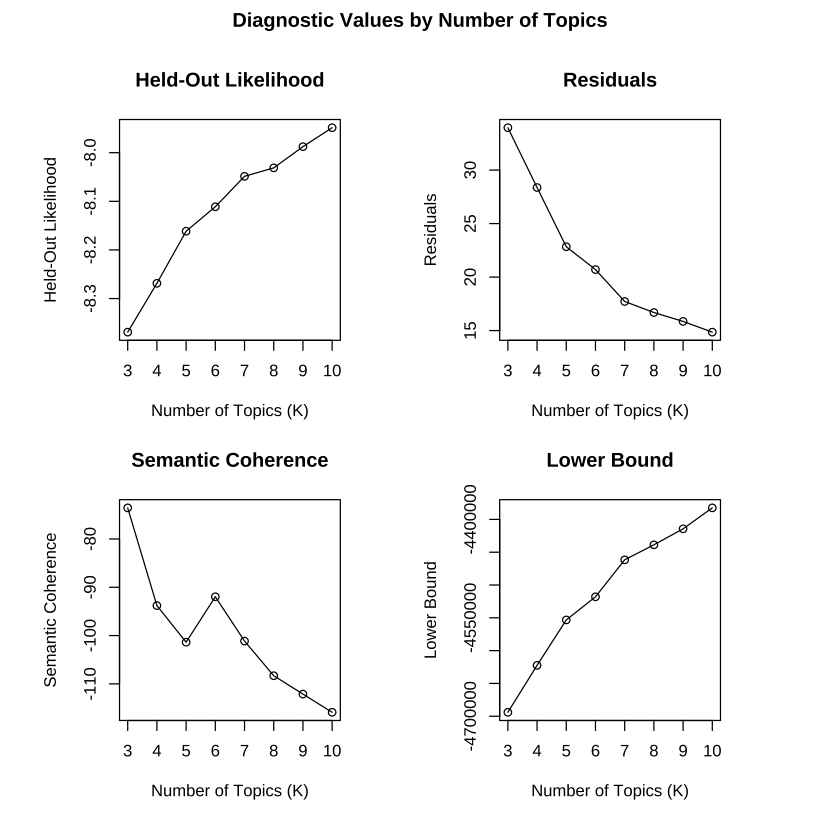

In [4]:
# show result as a plot
# as a result, 10 is the best
plot(topicN_storage)

### what does that mean?
- Exclusivity: The degree to which words appearing in a particular subject do not appear in another subject. Corresponding to diffusion validity.

- Semantic coherence: the degree to which words appearing in a particular subject with high probability appear simultaneously. Corresponding to convergent validity.

- Holdout likelihood: The extent to which model predictions persist when some of the data does not exist.

- Residual: An error that cannot explain the model with the input data.

**The higher the exclusivity, semantic coherence, and holdout likelihood, and the smaller the residual, the greater the appropriateness of the model.**

In [5]:
# define & train the model
stm_model <- stm(documents = out$documents, 
                 vocab = out$vocab, 
                 K = 10, 
                 prevalence = ~ Press + Date, 
                 data = out$meta, 
                 max.em.its = 200, 
                 init.type = "Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	..........
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.521) 
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.126, relative change = 1.465e-01) 
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -7.887, relative change

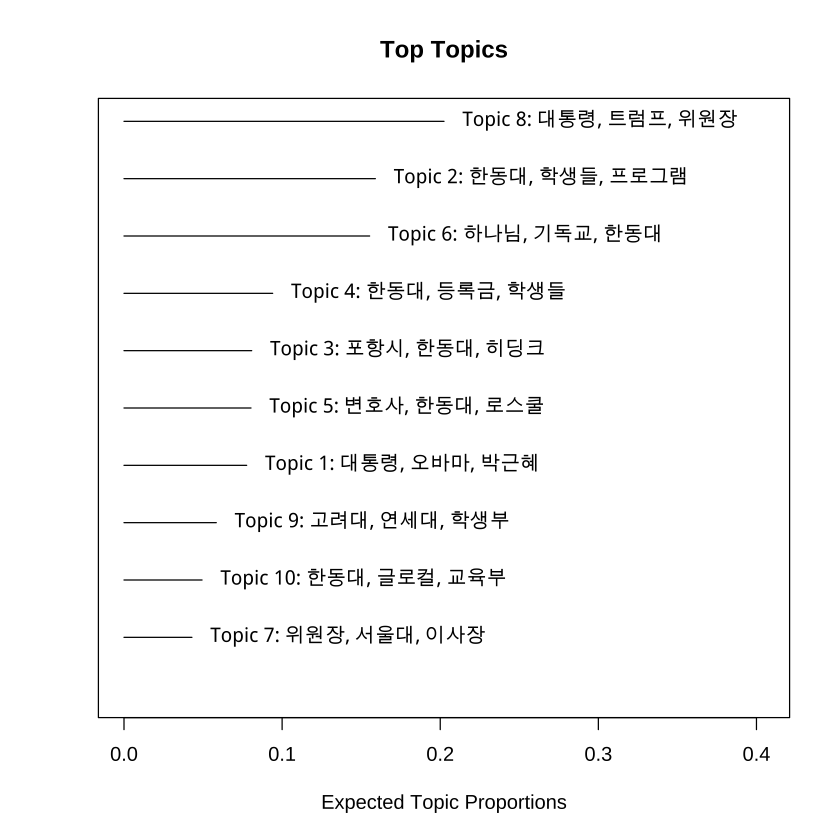

In [6]:
# show result as a plot
plot(stm_model, type = "summary")

In [7]:
# show topic's label
labelTopics(stm_model)

Topic 1 Top Words:
 	 Highest Prob: 대통령, 오바마, 박근혜, 한동대, 한반도, 동북아, 김준형 
 	 FREX: 경제민주화, north, 개혁세력, 청해부대, 기시다, 금호석유화학, 패러독스 
 	 Lift: 개헌론, 검수원복, 검찰국, 검찰정치, 경제동맹, 경제안보, 경제영역 
 	 Score: 오바마, 공화당, 대통령, 김준형, 개혁세력, 박근혜, 동북아 
Topic 2 Top Words:
 	 Highest Prob: 한동대, 학생들, 프로그램, 한동대학교, 하나님, 선교사, 글로벌 
 	 FREX: 김총장, 유니트윈, 사랑해, 홍이삭, kwmf, 기도실, 적정기술 
 	 Lift: 우즈베크, 글로벌교육원, 기업가정신, 유니트윈, 홍이삭, 가두행진, 가디언스 
 	 Score: 하나님, 선교사, 학생들, 김영길, unai, 장순흥, 반기문 
Topic 3 Top Words:
 	 Highest Prob: 포항시, 한동대, 히딩크, 장애인, 경북도, 옥수수, 포스텍 
 	 FREX: 히딩크, 옥수수, 드림필드, 울릉군, 유산균, 가속기, 준공식 
 	 Lift: 가스전, 간접피해, 강병중, 개정령, 거대과학, 거점도시, 건강문제 
 	 Score: 히딩크, 포항시, 옥수수, 드림필드, 경북도, 바이오, 배터리 
Topic 4 Top Words:
 	 Highest Prob: 한동대, 등록금, 학생들, 교육부, 대학들, 서울대, 학년도 
 	 FREX: 등록금, 교육여건, 대학평가, 적립금, 고교등급제, 광고주, 기여입학제 
 	 Lift: 개방이사제, 개성시대, 개학과, 개혁사례, 개혁추진, 게재수, 경쟁사들 
 	 Score: 등록금, 사정관, 학년도, 대교협, 사립대, 대학들, 교육부 
Topic 5 Top Words:
 	 Highest Prob: 변호사, 한동대, 로스쿨, 부친상, 사람들, 모친상, 대학원 
 	 FREX: 부친상, 모친상, 고양이, 삼성서울병원, 수용소, 장인상, 장모상 
 	 Lift: 배심제, 병역

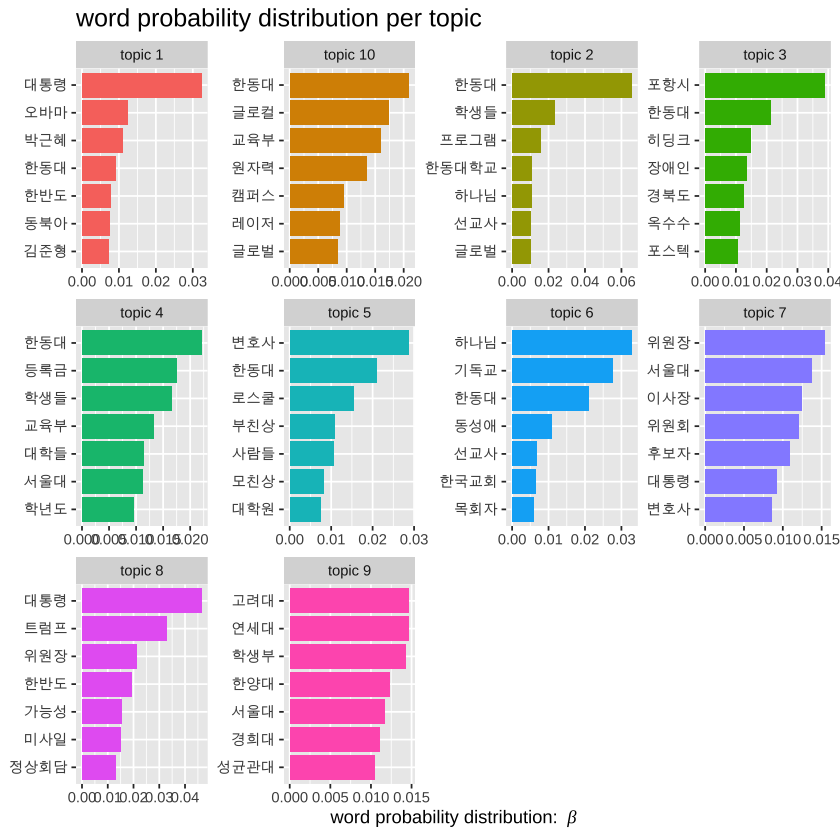

In [8]:
# Tidy the result into a summary data.frame
# Extract the beta value of the topic's probability distribution
td_beta <- stm_model |> tidy(matrix = 'beta') 

# visualization of topic's value
td_beta |>
  group_by(topic) |>
  slice_max(beta, n = 7) |>
  ungroup() |>
  mutate(topic = str_c("topic ", topic)) |>
  ggplot(aes(x = beta, 
             y = reorder_within(term, beta, topic),
             fill = topic)) +
  geom_col(show.legend = F) +
  scale_y_reordered() +
  facet_wrap(~topic, scales = "free") +
  labs(x = expression("word probability distribution: "~beta), y = NULL,
       title = "word probability distribution per topic") +
  theme(plot.title = element_text(size = 15))

### The result of Topic Modeling 

- Topic #1: Topic related to international politics

- Topic #2: Topic related to Globalization with Handong University

- Topic #3: Topic related to External achievements of Handong University

- Topic #4: Topic related to the policy of the Ministry of Education & Handong University

- Topic #5: Topic is about not included in the topic

- Topic #6: Topic related to Christianity at Handong University

- Topic #7: Topic related to News on alumni of Handong University

- Topic #8: Topic related to international politics

- Topic #9: Topic related to college entrance with Handong University

- Topic #10: Topic related to educational performance of Handong University